In [1]:
"""
Two-Body System Analysis
Investigating the central mass in Omega Centauri
Comparing acceleration vs velocity
"""

'\nTwo-Body System Analysis\nInvestigating the central mass in Omega Centauri\nComparing acceleration vs velocity\n'

In [2]:
"""
Timer
"""
import time
start_time = time.time()

In [3]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from PyAstronomy import pyasl
import astropy.units as u
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

import sys
sys.path
sys.path.append(r"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\two_body\orbit_utilities")
print(sys.path)
import two_body_utils as utils

['C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body', 'C:\\Users\\macke\\anaconda3\\python312.zip', 'C:\\Users\\macke\\anaconda3\\DLLs', 'C:\\Users\\macke\\anaconda3\\Lib', 'C:\\Users\\macke\\anaconda3', '', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\macke\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor', 'C:\\Users\\macke\\OneDrive - Saint Marys University\\Summer Research 2025\\two_body\\orbit_utilities']


In [4]:
# """
# Binary Orbit Calculations (8200; f(e) = 2e)
# """

# # ========================================================
# # 1. Sample Eccentricities from Thermal Distribution
# # ========================================================

# # Generate 100 eccentricities from thermal distribution f(e) = 2e
# # Use inverse transform sampling with F(e) = e² → e = sqrt(U), where U ~ Uniform[0,1]
# p = np.random.uniform(0, 1, utils.n_int)
# ecc_distribution = np.sqrt(p)

# # ========================================================
# # 2. Orbital Period and Time Array
# # ========================================================

# # Get sample orbital period (in seconds) using circular orbit approximation
# per_sample = utils.circular_period(semi_major=utils.semi_major_sample, speed=utils.v_xyz_sample)

# # Create array of time values over one orbital period
# # Time is in seconds if tau = 0 and period is in seconds
# t = np.linspace(utils.tau, per_sample.value, utils.n_int)

# # ========================================================
# # 3. Initialize Arrays for Position and Velocity (3D)
# # ========================================================

# # Arrays to store position and velocity vectors for both bodies
# r1 = np.zeros((utils.n_int,3))
# r2 = np.zeros((utils.n_int,3))
# v1 = np.zeros((utils.n_int,3))
# v2 = np.zeros((utils.n_int,3))

# # ========================================================
# # 4. Loop: Compute Orbital Dynamics with BinaryOrbit
# # ========================================================

# for k, (e_val, time) in enumerate(zip(ecc_distribution, t)):
#     # Initialize binary orbit with sampled eccentricity
#     bo = pyasl.BinaryOrbit(
#         m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
#         mtot = utils.mtot,               # Total mass (M_sun)
#         per = per_sample.value / 86400,  # Period in days
#         e = e_val,                       # Sampled eccentricity
#         tau = utils.tau,                 # Time of periastron (d)
#         Omega = utils.Omega,             # Ascending node longitude (deg)
#         w = utils.w,                     # Argument of periapsis (deg)
#         i = utils.i                      # Inclination (deg)
#     )

#     # Compute positions and velocities
#     r1[k], r2[k] = bo.xyzPos(time)     # Position vectors
#     v1[k], v2[k] = bo.xyzVel(time)     # Velocity vectors

# # ========================================================
# # 5. Calculate Derived Quantities: Velocity & Distance
# # ========================================================

# # Velocity magnitude in XY-plane (m/s)
# v1_xy = np.linalg.norm(v1[:, :2], axis=1)
# v2_xy = np.linalg.norm(v2[:, :2], axis=1)

# # Relative distance between the two masses (m)
# rd = np.sqrt(np.sum((r1 - r2) ** 2, axis=1))

# # Acceleration of the secondary in the XY-plane (km/s²)
# a_xy_secondary = utils.xy_orbital_acceleration_secondary(rd=rd*u.m) / 1e3  # convert m/s² to km/s²

# # ========================================================
# # 6. Create Data Summary Table
# # ========================================================

# # Convert time to days
# time_days = t / 86400

# # Assemble the results into a DataFrame
# summary_table = pd.DataFrame({
#     "Eccentricity": ecc_distribution,
#     "Timestep (days)": time_days,
#     "Relative Distance (km)": rd / 1000,
#     "XY Acceleration (km/s²)": a_xy_secondary,
#     "XY Velocity (km/s)": v2_xy / 1e3,  # m/s → km/s
# })

# # Summary table of accelerations
# summary_table


In [5]:
# """
# Plots of Acceleration vs Time and Acceleration vs Velocity
# for Calculated  Stars (8200; f(e) = 2e)
# """

# # === Acceleration vs Time Plot ===
# # Plot XY orbital acceleration [km/s²] vs time [days] for the secondary star
# # plt.plot(t / 86400, a_xy_secondary, '*', color="midnightblue")
# # plt.xlabel("Time [days]")
# # plt.ylabel("XY Acceleration [km/s²]")
# # plt.title("Sample Orbital Acceleration in XY")
# # plt.axvline(utils.tau, ls=':', c='k', label="Time of Periastron")
# # plt.legend()

# # # Generate a timestamped filename
# # sample_acc_title = "Sample_Orbital_Acceleration_wiht_Ecc_Distribution_"
# # timestamp_acc = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename_acc = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_title}{timestamp_acc}.png"

# # # Save and show the plot
# # # plt.savefig(filename_acc)
# # plt.show()

# # === Acceleration vs Velocity Plot ===
# # Plot XY orbital acceleration [km/s²] vs XY orbital velocity [km/s]
# plt.plot(v2_xy / 1e3, a_xy_secondary, '*', color="midnightblue")  # Convert velocity from m/s to km/s

# # Add vertical dashed line for escape velocity of the cluster
# escape_velocity = 62  # km/s
# plt.axvline(x=escape_velocity, color='crimson', linestyle='--', linewidth=1)

# # Create custom legend handles
# sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e")
# escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# # Get current plot legend handles and labels
# handles, labels = plt.gca().get_legend_handles_labels()

# # Append sample stars and escape velocity line
# handles.extend([sample_star, escape_vel_line])
# labels.extend([r"8200$M_{\odot}$; f(e) = 2e", 'Escape Velocity'])

# # Add final legend with no title
# plt.legend(handles=handles, labels=labels)

# # Axis labels and plot title
# plt.xlabel("Velocity [km/s]")
# plt.ylabel("Acceleration [km/s²]")
# plt.title(r"Calculated Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e)")

# # Use logarithmic scale for both axes
# plt.xscale("log")
# plt.yscale("log")

# # Generate a timestamped filename
# sample_acc_vel_title = "Calculated_Acceleration_vs_Velocity_8200_fe=2e_"
# timestamp_acc_vel = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename_acc_vel = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_vel_title}{timestamp_acc_vel}.png"

# # Save and show the plot
# #plt.savefig(filename_acc_vel)
# plt.show()


In [6]:
"""
Observed 2D Velocities and Accelerations 
----------------------------------------
Observational data for 7 high-velocity stars in Omega Centauri
Calculations of plane-of-sky accelerations and propagation of uncertainties
"""

# ========================================================
# 1. Input: Measured Proper Motion Velocities (v2D)
# ========================================================

# 2D velocities in the plane of the sky [km/s]
# Sources A–G
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2]) * u.km / u.s

# Corresponding 1σ uncertainties [km/s]
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9]) * u.km / u.s

# ========================================================
# 2. Input: Angular Accelerations from Astrometry (RA/Dec)
# ========================================================

# Accelerations in Right Ascension [mas/yr²]
a_ra = np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]) * u.mas / u.yr**2
a_ra_err = np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267]) * u.mas / u.yr**2

# Accelerations in Declination [mas/yr²]
a_dec = np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]) * u.mas / u.yr**2
a_dec_err = np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170]) * u.mas / u.yr**2

# ========================================================
# 3. Total Angular Acceleration and Uncertainty (Plane-of-Sky)
# ========================================================

# Total angular acceleration [mas/yr²]
a_total_masyr2 = np.sqrt(a_ra**2 + a_dec**2)

# Propagate uncertainty using partial derivatives
a_total_masyr2_err = np.sqrt(
    (a_ra * a_ra_err / a_total_masyr2)**2 +
    (a_dec * a_dec_err / a_total_masyr2)**2
)

# ========================================================
# 4. Conversion to Physical Acceleration [km/s²]
# ========================================================

# Convert angular acceleration to physical acceleration using cluster distance
a_total = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2, distance_km=utils.distance_km)
a_total_err = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2_err, distance_km=utils.distance_km)

# ========================================================
# 5. Create Summary Data Table
# ========================================================

# Build astropy table of all values
star_data = Table({
    "v2D": v2D,
    "v2D_err": v2D_err,
    "a_ra": a_ra,
    "a_ra_err": a_ra_err,
    "a_dec": a_dec,
    "a_dec_err": a_dec_err,
    "a_total": a_total,
    "a_total_err": a_total_err,
})

# Final table 
star_data


v2D,v2D_err,a_ra,a_ra_err,a_dec,a_dec_err,a_total,a_total_err
km / s,km / s,mas / yr2,mas / yr2,mas / yr2,mas / yr2,km / s2,km / s2
float64,float64,float64,float64,float64,float64,float64,float64
113.0,1.1,-0.0069,0.0083,0.0085,0.0098,8.930061383293236e-09,7.531455373299496e-09
66.6,4.1,0.0702,0.0239,0.0228,0.0157,6.02047938832453e-08,1.8958529783912896e-08
94.9,1.7,0.0028,0.0333,-0.006,0.0123,5.400731419743836e-09,1.4649029465648002e-08
77.9,2.0,0.0357,0.0177,-0.0194,0.0162,3.314142014778814e-08,1.4167818247443028e-08
69.6,0.8,0.0072,0.0042,-0.0009,0.0075,5.918566003817241e-09,3.483038561817065e-09
67.4,0.4,0.0052,0.0038,-0.0015,0.0038,4.4144539757184885e-09,3.0995661122692196e-09
66.2,1.9,-0.0197,0.0267,0.0173,0.017,2.1385320005943142e-08,1.8748565257835362e-08


In [7]:
# """
# Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (8200; f(e) = 2e)
# """

# # Plot
# plt.figure(figsize=(8, 6))
# plt.xlabel("Velocity [km/s]")
# plt.ylabel("Acceleration [km/s²]")
# plt.title(r"Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e)")
# plt.xscale("log")
# plt.yscale("log")

# # ========== Plot Observed Stars with Error Bars ==========

# # Colour and label settings for stars A–G
# colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
# labels = ["A", "B", "C", "D", "E", "F", "G"]

# # Plot each star with error bars (1σ in velocity and acceleration)
# for i in range(len(colours)):
#     plt.errorbar(
#         x=v2D[i].value,
#         y=a_total[i].value,
#         xerr=v2D_err[i].value,
#         yerr=a_total_err[i].value,
#         fmt="*",
#         label=labels[i],
#         color=colours[i],
#         capsize=3
#     )

# # ========== Plot Simulated Binary Stars ==========

# # Simulated secondary stars' velocities and accelerations
# plt.plot(v2_xy / 1e3, a_xy_secondary, '*', color="midnightblue")  # Convert m/s to km/s

# # ========== Plot Escape Velocity Threshold ==========

# av_escape_velocity = 62  # km/s average escape velocity
# plt.axvline(
#     x=av_escape_velocity,
#     color='crimson',
#     linestyle='--',
#     linewidth=1
# )

# # ========== Legend Handling ==========

# # Custom handles for legend
# sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e")
# escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# # Collect current legend entries (A–G)
# handles, legend_labels = plt.gca().get_legend_handles_labels()

# # Add custom entries
# handles.extend([sample_star, escape_vel_line])
# legend_labels.extend([r"8200$M_{\odot}$; f(e) = 2e", 'Escape Velocity'])

# # Final legend
# plt.legend(handles=handles, labels=legend_labels)

# # ========== Save Plot ==========

# # Create a timestamped filename for saving the plot
# plot_name ="Acceleration_vs_Velocity_8200_fe=2e_"
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{plot_name}_{timestamp}.png"

# # Save and show the plot
# plt.savefig(filename)
# plt.show()


In [8]:
# """
# Binary Orbit Calculations with IMBH_av_plots from Mark Gieles
# """

# # ========================================================
# # 1. Sample Eccentricities from a Thermal Distribution
# # ========================================================

# # Thermal distribution: f(e) = 2e → F(e) = e^2 → e = sqrt(u) for u ∈ [0, 1]
# p_Gieles = np.random.uniform(0, 1, utils.n_int)
# ecc_distribution_Gieles = np.sqrt(p_Gieles)

# # ========================================================
# # 2. Define Orbital Period and Time Steps
# # ========================================================

# # Compute sample orbital period from circular velocity (returns value in seconds)
# per_sample_Gieles = utils.circular_period(semi_major=utils.a_IMBH_av_plots, speed=utils.v_xyz_sample)

# # Generate n_int time steps from periapsis (tau) to one full orbital period
# t_Gieles = np.linspace(utils.tau, per_sample_Gieles.value, utils.n_int)  # seconds

# # ========================================================
# # 3. Initialize Arrays for Orbit Results
# # ========================================================

# # Shape: (n_eccentricities, n_timesteps, 3D xyz)
# r1_Gieles = np.zeros((utils.n_int,3))                                  # Primary position
# r2_Gieles = np.zeros((utils.n_int,3))                                   # Secondary position
# v1_Gieles = np.zeros((utils.n_int,3))                                   # Primary velocity
# v2_Gieles = np.zeros((utils.n_int,3))                                  # Secondary velocity

# # ========================================================
# # 4. Compute Positions and Velocities for Each Eccentricity
# # ========================================================

# for k, (e_val, time) in enumerate(zip(ecc_distribution_Gieles, t_Gieles)):
#     # Setup orbit with IMBH + star (mass ratio = 1:200,000)
#     bo_Gieles = pyasl.BinaryOrbit(
#         m2m1 = 1/200000,                     # mass ratio
#         mtot = 200000,                       # total mass in solar masses
#         per = per_sample_Gieles.value / 86400,  # convert period to days
#         e = e_val,
#         tau = utils.tau,
#         Omega = utils.Omega,
#         w = utils.w,
#         i = utils.i
#     )
#     r1_Gieles[k], r2_Gieles[k] = bo_Gieles.xyzPos(time)
#     v1_Gieles[k], v2_Gieles[k] = bo_Gieles.xyzVel(time)

# # ========================================================
# # 5. Compute Derived Quantities (Distance, Velocity, Acceleration)
# # ========================================================

# # Velocity magnitude in xy-plane [m/s]
# v1_xy_Gieles = np.linalg.norm(v1_Gieles[:, :2], axis=1)
# v2_xy_Gieles = np.linalg.norm(v2_Gieles[:, :2], axis=1)

# # Relative distance between primary and secondary [m]
# rd_Gieles = np.linalg.norm(r1_Gieles - r2_Gieles, axis=1)

# # Acceleration of secondary body in xy-plane [km/s²]
# a_xy_secondary_Gieles = utils.xy_orbital_acceleration_secondary(rd=rd_Gieles*u.m) / 1e3

# # ========================================================
# # 6. Summary Table for Output or Plotting
# # ========================================================

# # Convert seconds to days for output
# time_days_Gieles = t_Gieles / 86400


# # Build DataFrame
# summary_table_Gieles = pd.DataFrame({
#     "Eccentricity": ecc_distribution_Gieles,
#     "Timestep (days)": time_days_Gieles,
#     "Relative Distance (km)": rd_Gieles / 1000,  # Convert to km
#     "Acceleration of Secondary Body (km/s^2)": a_xy_secondary_Gieles,
#     "XY Velocity (km/s)": v2_xy_Gieles / 1e3,
# })

# # ========================================================
# # 7. Plotting Results
# # ========================================================

# # Histogram of Eccentricity Distribution 
# plt.figure(figsize=(8, 5))
# plt.hist(ecc_distribution_Gieles, bins=50, color='teal')
# plt.xlabel("Eccentricity")
# plt.ylabel("Count")
# plt.title("Sampled Eccentricity Distribution (Thermal: f(e) = 2e)")
# plt.grid(True, ls="--", linewidth=0.5)
# plt.tight_layout()
# plt.show()

# # Histogram of Acceleration Distribution 
# plt.figure(figsize=(8, 5))
# plt.hist(a_xy_secondary_Gieles, bins=100, log=True)
# plt.xlabel("Acceleration (km/s²)")
# plt.ylabel("Count")
# plt.xscale("log")
# plt.title("Distribution of Secondary Body Accelerations")
# plt.grid(True, which="both", ls="--", linewidth=0.5)
# plt.tight_layout()
# plt.show()

# # Summary table of sample accelerations
# summary_table_Gieles

In [9]:
# """
# Binary Orbit Calculations (8200; f(e) = 2e; nu)
# """

# # ========================================================
# # 1. Sample Eccentricities and Mean Anomalies
# # ========================================================

# # Sample eccentricities from the thermal distribution f(e) = 2e using inverse transform sampling:
# # Let p ~ Uniform(0,1), then e = sqrt(p) ensures f(e) ∝ 2e
# p = np.random.uniform(0, 1, utils.n_int)
# eccentricities = np.sqrt(p)

# # Sample mean anomalies (M) uniformly from [0, 2π]
# # This reflects uniform motion in time along each orbit
# # Non-unifrom distribution of true annomaly is calculated later
# mean_anomaly = np.random.uniform(0, 2 * np.pi, utils.n_int)

# # ========================================================
# # 2. Compute Eccentric and True Anomalies
# # ========================================================

# # Initialize an array to store eccentric anomalies (E)
# # Shape: (n_eccentricities, n_mean_anomalies)
# ecc_anomaly = np.zeros((utils.n_int))

# # Solve Kepler's equation: M = E - e*sin(E) → E, for each (e, M) pair
# for k, (e_val, m_anmly) in enumerate(zip(eccentricities, mean_anomaly)):
#     ecc_anomaly[k] = utils.eccentric_annomaly(M=m_anmly, e=e_val)

# # Initialize an array to store true anomalies (ν)
# true_anomaly = np.zeros((utils.n_int))

# # Convert each eccentric anomaly and eccentricity to true anomaly 
# for k, (e_val, E_val) in enumerate(zip(eccentricities, ecc_anomaly)):
#         true_anomaly[k] = utils.true_anomaly(E=E_val, e=e_val)

# # ========================================================
# # 3. Compute Orbital Distances from Center of Mass
# # ========================================================

# # Compute instantaneous radial distance (r) from center of mass
# # for the primary and secondary components in meters calculated with semi-major axis values from the Omega Centauri paper (converted to meters)
# a_primary = np.zeros((utils.n_int))
# for k, (e_val, t_anmly) in enumerate(zip(eccentricities, true_anomaly)):
#     a_primary[k] = utils.com_radius(a=utils.semi_major_primary.to(u.m).value, e=e_val, nu=t_anmly)     #m
    
# a_secondary = np.zeros((utils.n_int))
# for k, (e_val, t_anmly) in enumerate(zip(eccentricities, true_anomaly)):
#     a_secondary[k] = utils.com_radius(a=utils.semi_major_secondary.to(u.m).value, e=e_val, nu=t_anmly)    #m

# # Compute the separation (r) in meters between the two bodies at each true anomaly
# relative_distance = np.zeros((utils.n_int))
# for k, (a_pri, a_sec, e_val, t_anmly) in enumerate(zip(a_primary, a_secondary, eccentricities, true_anomaly)):
#     relative_distance[k] = utils.relative_distance(a_primary=a_pri, a_secondary=a_sec, e=e_val, nu=t_anmly)



# # ========================================================
# # 4. Compute XY-Plane Accelerations and Speeds with utils
# # ========================================================

# # The acceleration of the secondary body in the plane of the sky
# # Units outputted: km/s² (but requires input distances in meters)
# a_xy_nu = utils.xy_orbital_acceleration_secondary(rd=relative_distance*u.m).value

# # The Orbital velocity of the secondary
# # Units outputted: m/s² (requires input distances in meters)
# orbital_speed_nu = np.zeros((utils.n_int))*u.m/u.s
# for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary*u.m, eccentricities, true_anomaly)):
#     orbital_speed_nu[k] = utils.orbital_speed(a = a_sec, e = e_val, nu=t_anmly)

# # Convert to velocity in the plane of the sky
# # Useful approximation when inclination i = o (default value in utils)
# # Note: CANNOT convert to velocity in the plane of the sky using cos(inc_rad) ==== approximation works for inclination = 0 only!!!
# # Useful to compare with v2_xy_nu
# xy_orbital_speed_nu= orbital_speed_nu*np.cos(utils.i)


# # ========================================================
# # 5. Compute Orbital Velocity with BinaryOrbit
# # ========================================================

# # Orbital period in days using a_secondary (in meters) orbital_speed in m/s
# per_nu_days = np.zeros(utils.n_int) * u.day
# for k, (a_sec, v_orb) in enumerate(zip(a_secondary, orbital_speed_nu)):
#     per_nu_days[k] = utils.orbital_period_days(semi_major = a_sec*u.m, speed= v_orb)
    
# # Calculate timesteps from true anomalies in seconds
# t_nu = np.zeros((utils.n_int))*u.s
# for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary*u.m, eccentricities, true_anomaly)):
#     t_nu[k]= utils.true_anomaly_to_time(nu = t_anmly, e = e_val, a = a_sec)

# # Convert timesteps to days to compare with period in days
# t_nu_days = t_nu.to(u.day)


# # Initialize empty array for velocities of primary and secondary bodies in the binary orbit
# v1_nu = np.zeros((utils.n_int, 3))
# v2_nu = np.zeros((utils.n_int, 3))

# for k, e_val in enumerate(eccentricities):
#     # Initialize binary orbit with sampled eccentricity
#     bo = pyasl.BinaryOrbit(
#         m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
#         mtot = utils.mtot,               # Total mass (M_sun)
#         per = per_nu_days[k].value,      # Period in days
#         e = e_val,                       # Sampled eccentricity
#         tau = utils.tau,                 # Time of periastron (d)
#         Omega = utils.Omega,             # Ascending node longitude (deg)
#         w = utils.w,                     # Argument of periapsis (deg)
#         i = utils.i                      # Inclination (deg)
#     )
#     # Wrap time to [0, period) to avoid going beyond one orbit
#     t_nu_wrapped = (t_nu_days[k] % per_nu_days[k]).to(u.s).value  # In seconds, scalar

#     # Compute velocities
#     v1_nu[k], v2_nu[k] = bo.xyzVel(t_nu_wrapped)


# # Velocity magnitude in XY-plane (m/s)
# v1_xy_nu = np.linalg.norm(v1_nu[:, :2], axis=1)
# v2_xy_nu = np.linalg.norm(v2_nu[:, :2], axis=1)

# # ========================================================
# # 5. Plot the Distributions
# # ========================================================

# # Plot histogram of true anomalies
# plt.hist(true_anomaly.flatten(), bins=utils.n_int, density=True, color='teal')
# plt.xlabel('True Anomaly (radians)')
# plt.ylabel('Probability Density')
# plt.title('Distribution of Modelled True Anomalies')
# plt.grid(True, linestyle='--', linewidth=0.5)
# plt.xlim([0,2*np.pi])
# plt.tight_layout()
# plt.show()

# # Plot histogram of orbital accelerations
# plt.hist(a_xy_nu.flatten(), bins=utils.n_int, log=True)
# plt.xscale("log")  # Logarithmic x-axis due to wide range of accelerations
# plt.xlabel('Acceleration (km/s²)')
# plt.ylabel('Count')
# plt.title('Distribution of Modelled Star Accelerations')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.tight_layout()
# plt.show()


In [10]:
# """
# Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (8200; f(e) = 2e; nu)
# """

# # Plot
# plt.figure(figsize=(8, 6))
# plt.xlabel("Velocity [km/s]")
# plt.ylabel("Acceleration [km/s²]")
# plt.title(r"Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e; nu)")
# plt.xscale("log")
# plt.yscale("log")

# # ========== Plot Observed Stars with Error Bars ==========

# # Colour and label settings for stars A–G
# colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
# labels = ["A", "B", "C", "D", "E", "F", "G"]

# # Plot each star with error bars (1σ in velocity and acceleration)
# for i in range(len(colours)):
#     plt.errorbar(
#         x=v2D[i].value,
#         y=a_total[i].value,
#         xerr=v2D_err[i].value,
#         yerr=a_total_err[i].value,
#         fmt="*",
#         label=labels[i],
#         color=colours[i],
#         capsize=3
#     )

# # ========== Plot Simulated Binary Stars ==========

# # Simulated secondary stars' velocities and accelerations
# plt.plot(v2_xy_nu / 1e3, a_xy_nu, '*', color="midnightblue")  # Convert m/s to km/s for velocity

# # ========== Plot Escape Velocity Threshold ==========

# av_escape_velocity = 62  # km/s average escape velocity
# plt.axvline(
#     x=av_escape_velocity,
#     color='crimson',
#     linestyle='--',
#     linewidth=1
# )

# # ========== Legend Handling ==========

# # Custom handles for legend
# sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e; nu")
# escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# # Collect current legend entries (A–G)
# handles, legend_labels = plt.gca().get_legend_handles_labels()

# # Add custom entries
# handles.extend([sample_star, escape_vel_line])
# legend_labels.extend([r"8200$M_{\odot}$; f(e) = 2e; nu", 'Escape Velocity'])

# # Final legend
# plt.legend(handles=handles, labels=legend_labels)


# # ========== Summary Table ========== 

# summary_table_nu = pd.DataFrame({
#     "Eccentricity": eccentricities,
#     "True Anomaly (rad)": true_anomaly,
#     "Timestep (days)": t_nu_days.value,  # .value to get rid of units
#     "Relative Distance (km)": relative_distance / 1000,  # m to km
#     "XY Acceleration (km/s²)": a_xy_nu,
#     "XY Velocity (km/s)": v2_xy_nu / 1e3  # m/s to km/s
# })

# # Identify max and min rows by velocity and acceleration
# max_vel_row = summary_table_nu.loc[summary_table_nu["XY Velocity (km/s)"].idxmax()]
# min_vel_row = summary_table_nu.loc[summary_table_nu["XY Velocity (km/s)"].idxmin()]
# max_acc_row = summary_table_nu.loc[summary_table_nu["XY Acceleration (km/s²)"].idxmax()]
# min_acc_row = summary_table_nu.loc[summary_table_nu["XY Acceleration (km/s²)"].idxmin()]

# # Label each row
# max_vel_row["Note"] = "MAX Velocity"
# min_vel_row["Note"] = "MIN Velocity"
# max_acc_row["Note"] = "MAX Acceleration"
# min_acc_row["Note"] = "MIN Acceleration"

# # Fill 'Note' column in the rest of the table with empty strings
# summary_table_nu["Note"] = ""

# # Combine new rows with original table
# summary_table_nu = pd.concat([
#     pd.DataFrame([max_vel_row, min_vel_row, max_acc_row, min_acc_row]),
#     summary_table_nu
# ])

# # ========== Save Plot ==========

# # Create a timestamped filename for saving the plot
# nu_plot_name ="Acceleration_vs_Velocity_8200_fe=2e_nu"
# nu_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# nu_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{nu_plot_name}_{nu_timestamp}.png"

# # Save and show the plot
# plt.savefig(nu_filename)
# plt.show()
# summary_table_nu

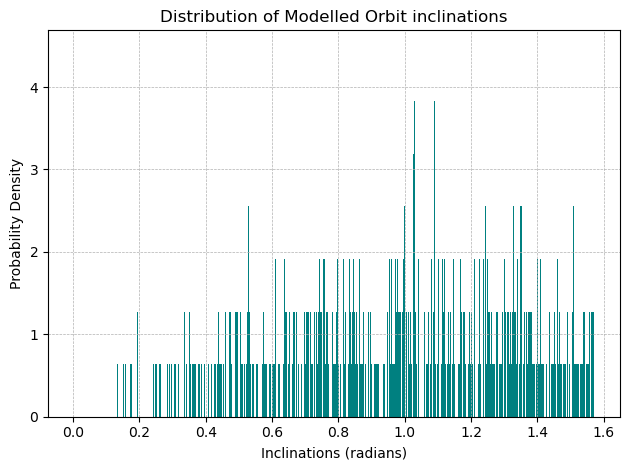

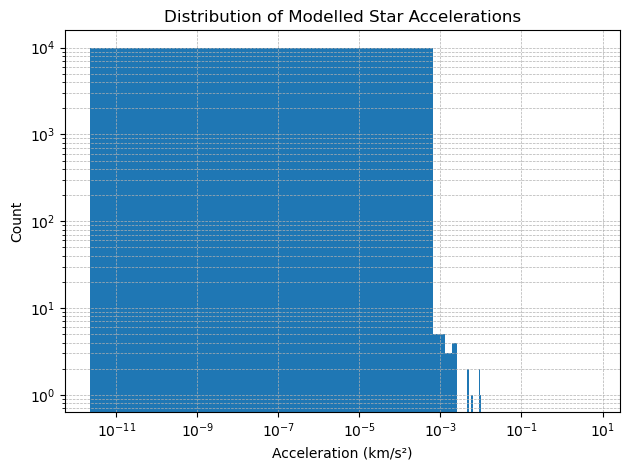

In [11]:
"""
Binary Orbit Calculations (m_primary; f(e) = 2e; nu; i = arccos(u))
"""

# ========================================================
# 1. Sample Eccentricities, Inclinations and Mean Anomalies
# ========================================================

# Sample eccentricities from the thermal distribution f(e) = 2e using inverse transform sampling:
# Let p ~ Uniform(0,1), then e = sqrt(p) ensures f(e) ∝ 2e
p_i = np.random.uniform(0, 1, utils.n_int)
eccentricities_i = np.sqrt(p_i)

# Sample mean anomalies (M) uniformly from [0, 2π]
# This reflects uniform motion in time along each orbit
# Non-unifrom distribution of true annomaly is calculated later
mean_anomaly_i = np.random.uniform(0, 2*np.pi, utils.n_int)

# Sample inclinations by sampling uniform u=cos(i) from 0 to one, reflecting inclinations from zero to 90 degrees
u_inc = np.random.uniform(0, 1, utils.n_int)
inc_rad = np.arccos(u_inc)
# Convert to degrees for BinaryOrbit
inclinations_deg = np.degrees(inc_rad)

# ========================================================
# 2. Compute Eccentric and True Anomalies
# ========================================================

# Initialize an array to store eccentric anomalies (E)
# Shape: (n_eccentricities, n_mean_anomalies)
ecc_anomaly_i = np.zeros((utils.n_int))

# Solve Kepler's equation: M = E - e*sin(E) → E, for each (e, M) pair
for k, (e_val, m_anmly) in enumerate(zip(eccentricities_i, mean_anomaly_i)):
    ecc_anomaly_i[k] = utils.eccentric_annomaly(M=m_anmly, e=e_val)

# Initialize an array to store true anomalies (ν)
true_anomaly_i = np.zeros((utils.n_int))

# Convert each eccentric anomaly and eccentricity to true anomaly 
for k, (e_val, E_val) in enumerate(zip(eccentricities_i, ecc_anomaly_i)):
        true_anomaly_i[k] = utils.true_anomaly(E=E_val, e=e_val)

# ========================================================
# 3. Compute Orbital Distances from Center of Mass
# ========================================================

# Compute instantaneous radial distance (r) from center of mass
# for the primary and secondary components in meters
a_primary_i = np.zeros((utils.n_int))
for k, (e_val, t_anmly) in enumerate(zip(eccentricities_i, true_anomaly_i)):
    a_primary_i[k] = utils.com_radius(a=utils.semi_major_primary.to(u.m).value, e=e_val, nu=t_anmly)     #m
    
a_secondary_i = np.zeros((utils.n_int))
for k, (e_val, t_anmly) in enumerate(zip(eccentricities_i, true_anomaly_i)):
    a_secondary_i[k] = utils.com_radius(a=utils.semi_major_secondary.to(u.m).value, e=e_val, nu=t_anmly)    #m

# Compute the separation (r) in meters between the two bodies at each true anomaly
relative_distance_i = np.zeros((utils.n_int))
for k, (a_pri, a_sec, e_val, t_anmly) in enumerate(zip(a_primary_i, a_secondary_i, eccentricities_i, true_anomaly_i)):
    relative_distance_i[k] = utils.relative_distance(a_primary=a_pri, a_secondary=a_sec, e=e_val, nu=t_anmly)



# ========================================================
# 4. Compute XY-Plane Accelerations and speed with utils
# ========================================================

# The acceleration of the secondary body in the plane of the sky
# Units outputted: km/s² (but requires input distances in meters)
# a_xy_i = utils.xy_orbital_acceleration_secondary(rd=relative_distance_i, i = inc_rad).value
a_xy_i = utils.xy_orbital_acceleration_secondary(rd=relative_distance_i*u.m, i = inc_rad).value

# The Orbital velocity of the secondary
# Units outputted: m/s (requires input distances in meters)
# Note: CANNOT convert to velocity in the plane of the sky using cos(inc_rad) ==== approximation works for inclination = 0 only!!!
# This is useful for calculating the orbital period
orbital_speed_i = np.zeros((utils.n_int))*u.m/u.s
for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary_i*u.m, eccentricities_i, true_anomaly_i)):
    orbital_speed_i[k] = utils.orbital_speed(a = a_sec, e = e_val, nu=t_anmly)


# ========================================================
# 4. Compute Orbital Velocity with BinaryOrbit
# ========================================================

# Orbital period in days using a_secondary_i (in meters) orbital_speed in m/s
per_i_days = np.zeros(utils.n_int) * u.day
for k, (a_sec, v_orb) in enumerate(zip(a_secondary_i, orbital_speed_i)):
    per_i_days[k] = utils.orbital_period_days(semi_major = a_sec*u.m, speed= v_orb)
    
# Calculate timesteps from true anomalies in seconds
t_i = np.zeros((utils.n_int))*u.s
for k, (a_sec, e_val, t_anmly) in enumerate(zip(a_secondary_i*u.m, eccentricities_i, true_anomaly_i)):
    t_i[k]= utils.true_anomaly_to_time(nu = t_anmly, e = e_val, a = a_sec)

# Convert timesteps to days to compare with period in days
t_i_days = t_i.to(u.day)

# Initialize empty array for velocities of primary (1) and secondary (2) bodies in the binary orbit
v1_i = np.zeros((utils.n_int, 3))
v2_i = np.zeros((utils.n_int, 3))

for k, (e_val, i_val) in enumerate(zip(eccentricities_i, inclinations_deg)):
        # Create BinaryOrbit instance for current e and i
        bo = pyasl.BinaryOrbit(
            m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
            mtot = utils.mtot,               # Total mass (M_sun)
            per = per_i_days.value[k],              # Period in days
            e = e_val,                       # Sampled eccentricity
            tau = utils.tau,                 # Time of periastron (d)
            Omega = utils.Omega,             # Ascending node longitude (deg)
            w = utils.w,                     # Argument of periapsis (deg)
            i=i_val                          # Inclination (deg)
        )

        # Wrap time to [0, period) to avoid going beyond one orbit
        t_i_wrapped = (t_i_days[k] % per_i_days[k]).to(u.s).value  # In seconds, scalar
    
        # Compute velocities at each timestep
        v1_i[k], v2_i[k] = bo.xyzVel(t_i_wrapped)


# Velocity magnitude in XY-plane (m/s)
v1_xy_i = np.linalg.norm(v1_i[:, :2], axis=1)
v2_xy_i = np.linalg.norm(v2_i[:, :2], axis=1)

# ========================================================
# 5. Plot the Distributions
# ========================================================

# Plot histogram of inclinations in radians
plt.hist(inc_rad.flatten(), bins= utils.n_int, density=True, color='teal')
plt.xlabel('Inclinations (radians)')
plt.ylabel('Probability Density')
plt.title('Distribution of Modelled Orbit inclinations')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of orbital accelerations
plt.hist(a_xy_i.flatten(), bins= utils.n_int, log=True)
plt.xscale("log")  # Logarithmic x-axis due to wide range of accelerations
plt.xlabel('Acceleration (km/s²)')
plt.ylabel('Count')
plt.title('Distribution of Modelled Star Accelerations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


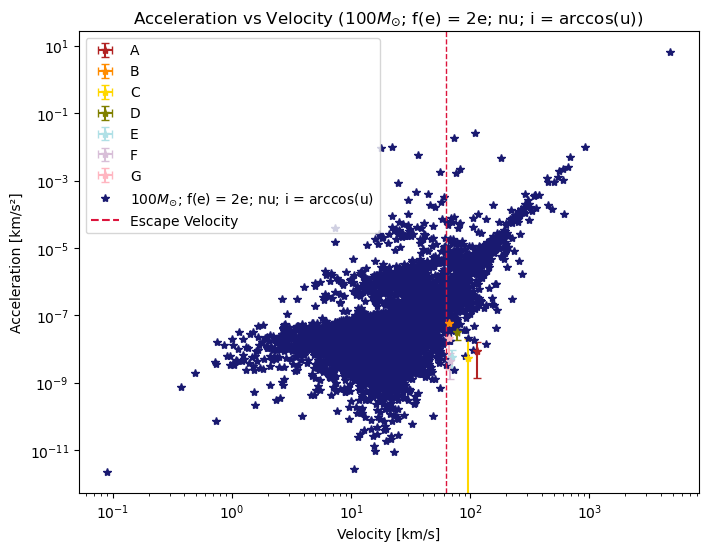

,Eccentricity,Inclination (rad),True Anomaly (rad),Timestep (days),Relative Distance (km),XY Acceleration (km/s²),XY Velocity (km/s),Label
0,0.991501,1.107634,1.049607,0.001770,9.603446e+08,6.429110e+00,4782.290789,Max Acceleration
1,0.970405,1.570755,3.290406,18217.920721,1.564582e+13,2.243855e-12,0.089286,Min Acceleration
2,0.991501,1.107634,1.049607,0.001770,9.603446e+08,6.429110e+00,4782.290789,Max Velocity
3,0.970405,1.570755,3.290406,18217.920721,1.564582e+13,2.243855e-12,0.089286,Min Velocity
4,0.788656,1.520273,2.759820,4966.826073,1.486830e+13,3.031786e-09,27.015291,
...,...,...,...,...,...,...,...,...
9999,0.846490,0.828179,2.637002,1979.718468,8.958687e+12,1.118175e-07,37.326184,
10000,0.792871,1.139403,2.643495,3049.755497,1.120078e+13,4.423164e-08,32.450656,
10001,0.881741,1.329241,3.343032,19423.532174,2.000060e+13,7.936155e-09,7.674519,
10002,0.603926,1.430758,2.928906,9804.128067,1.798552e+13,5.726549e-09,21.566013,


In [12]:
"""
Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (m_primary; f(e) = 2e; nu: i = arccos(u))
"""

# Plot
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(fr"Acceleration vs Velocity ({utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))")

plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

# Colour and label settings for stars A–G
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

# Plot each star with error bars (1σ in velocity and acceleration)
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3
    )

# ========== Plot Simulated Binary Stars ==========

# Simulated secondary stars' velocities and accelerations
plt.plot(v2_xy_i.flatten() / 1e3, a_xy_i.flatten(), '*', color="midnightblue")

# ========== Plot Escape Velocity Threshold ==========

av_escape_velocity = 62  # km/s average escape velocity
plt.axvline(
    x=av_escape_velocity,
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== Legend Handling ==========

# Custom handles for legend
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
                            label=fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Collect current legend entries (A–G)
handles, legend_labels = plt.gca().get_legend_handles_labels()

# Add custom entries
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)", 'Escape Velocity'])

# Final legend
plt.legend(handles=handles, labels=legend_labels)


# ========== Save Plot ==========

# Create a timestamped filename for saving the plot
i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_fe=2e_nu_i_"
i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{i_plot_name}_{i_timestamp}.png"


# ========== Summary Table ========== 

summary_table_i = pd.DataFrame({
    "Eccentricity": eccentricities_i,
    "Inclination (rad)": inc_rad,
    "True Anomaly (rad)": true_anomaly_i,
    "Timestep (days)": t_i_days,
    "Relative Distance (km)": relative_distance_i,
    "XY Acceleration (km/s²)": a_xy_i,
    "XY Velocity (km/s)": v2_xy_i/1e3
})

# Get rows with max and min acceleration
max_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmax()]
min_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmin()]

# Get rows with max and min velocity
max_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmax()]
min_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmin()]

# Label the rows for clarity
max_acc_row["Label"] = "Max Acceleration"
min_acc_row["Label"] = "Min Acceleration"
max_vel_row["Label"] = "Max Velocity"
min_vel_row["Label"] = "Min Velocity"

# Fill the rest with empty strings to avoid NaNs
summary_table_i["Label"] = ""

# Create a new DataFrame for the labeled rows
top_rows = pd.DataFrame([max_acc_row, min_acc_row, max_vel_row, min_vel_row])

# Concatenate labeled top rows with the full table
summary_table_i = pd.concat([top_rows, summary_table_i], ignore_index=True)

# Display table
# Save and show the plot
plt.savefig(i_filename)
plt.show()
summary_table_i


In [13]:
print(utils.m_primary)
print(utils.semi_major_sample.to(u.au))
print(utils.n_int)

100
49.99999999999999 AU
10000


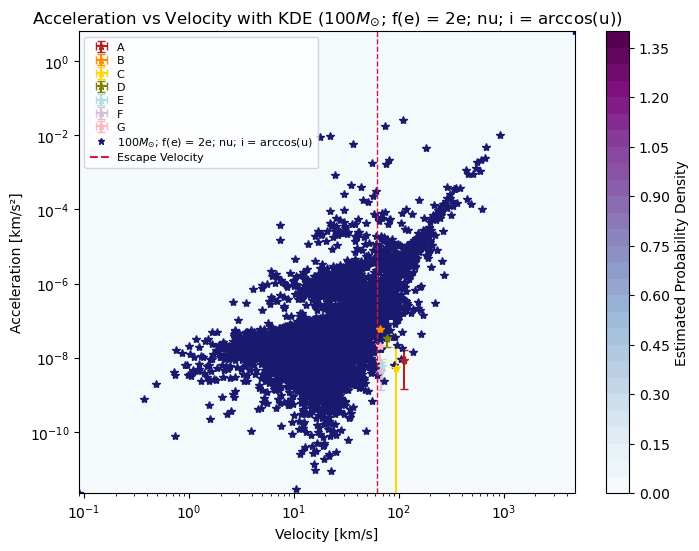

,Eccentricity,Inclination (rad),True Anomaly (rad),Timestep (days),Relative Distance (km),XY Acceleration (km/s²),XY Velocity (km/s),Label
0,0.991501,1.107634,1.049607,0.001770,9.603446e+08,6.429110e+00,4782.290789,Max Acceleration
1,0.970405,1.570755,3.290406,18217.920721,1.564582e+13,2.243855e-12,0.089286,Min Acceleration
2,0.991501,1.107634,1.049607,0.001770,9.603446e+08,6.429110e+00,4782.290789,Max Velocity
3,0.970405,1.570755,3.290406,18217.920721,1.564582e+13,2.243855e-12,0.089286,Min Velocity
4,0.788656,1.520273,2.759820,4966.826073,1.486830e+13,3.031786e-09,27.015291,
...,...,...,...,...,...,...,...,...
9999,0.846490,0.828179,2.637002,1979.718468,8.958687e+12,1.118175e-07,37.326184,
10000,0.792871,1.139403,2.643495,3049.755497,1.120078e+13,4.423164e-08,32.450656,
10001,0.881741,1.329241,3.343032,19423.532174,2.000060e+13,7.936155e-09,7.674519,
10002,0.603926,1.430758,2.928906,9804.128067,1.798552e+13,5.726549e-09,21.566013,


In [14]:
"""
Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars with Kernel Density Estimate
(m_primary; f(e) = 2e; nu: i = arccos(u))
"""

# Plot
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(fr"Acceleration vs Velocity with KDE ({utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))")

plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

# Colour and label settings for stars A–G
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

# Plot each star with error bars (1σ in velocity and acceleration)
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3 
    )

# ========== Plot Simulated Binary Stars ==========

# Simulated secondary stars' velocities and accelerations
plt.plot(v2_xy_i.flatten() / 1e3, a_xy_i.flatten(), '*', color="midnightblue")

# ========== Plot Escape Velocity Threshold ==========

av_escape_velocity = 62  # km/s average escape velocity
plt.axvline(
    x=av_escape_velocity,
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== Kernel Density Estimate (KDE) for Simulated Stars ========== 

# Convert velocities from m/s to km/s by dividing by 1000
velocities = v2_xy_i / 1e3         # velocities in km/s
accelerations = a_xy_i            # accelerations in km/s²

# Take the base-10 logarithm of the velocities and accelerations
# This is needed because the plot is on a log-log scale
log_velocities = np.log10(velocities)        # log₁₀(velocity)
log_accelerations = np.log10(accelerations)  # log₁₀(acceleration)

# Stack the log-transformed data into a 2D array
# This format is required by the KDE function
# Shape will be (2, N), where N is the number of data points
values = np.vstack([log_velocities, log_accelerations])

# Create a grid of (x, y) positions where the KDE will be evaluated
# 100j means 100 grid points in each direction
x_grid, y_grid = np.mgrid[
    log_velocities.min():log_velocities.max():100j,
    log_accelerations.min():log_accelerations.max():100j
]

# Flatten the grid and stack it for input to the KDE function
# Each column is a 2D point: [log_velocity, log_acceleration]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Kernel density estimate (KDE)
# This estimates the probability density function based on the data
kernel = stats.gaussian_kde(values)

# Evaluate the KDE on the grid and reshape the result
# Z will be a 2D array representing the estimated density at each grid point
Z = np.reshape(kernel(positions).T, x_grid.shape)

# Convert the log-space grid back to linear values for plotting
# This matches the original log-log plot scale
X_plot = 10 ** x_grid
Y_plot = 10 ** y_grid

# Plot the KDE as a filled contour plot
# levels=30 means 30 contour levels (the number of shaded bands)
# alpha=0.5 makes the plot semi-transparent so points underneath are still visible
contour = plt.contourf(X_plot, Y_plot, Z, levels=30, cmap='BuPu', alpha=1)

# Add a colorbar to show the density scale
cbar = plt.colorbar(contour)
cbar.set_label("Estimated Probability Density")

# ========== Legend Handling ==========

# Custom handles for legend
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
                            label=fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Collect current legend entries (A–G)
handles, legend_labels = plt.gca().get_legend_handles_labels()

# Add custom entries
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([fr"{utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u)", 'Escape Velocity'])

# Final legend
plt.legend(
    handles=handles,
    labels=legend_labels,
    fontsize=8,               # Smaller text
    loc='best',               # Auto-place in best spot
    markerscale=0.8,          # Scale down markers
    handletextpad=0.4,        # Space between marker and text
    borderpad=0.5,            # Padding inside the legend box
    labelspacing=0.3          # Space between legend entries
)


# ========== Save Plot ==========

# Create a timestamped filename for saving the plot
i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_fe=2e_nu_i_KDE_"
i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{i_plot_name}_{i_timestamp}.png"


# ========== Summary Table ========== 

summary_table_i = pd.DataFrame({
    "Eccentricity": eccentricities_i,
    "Inclination (rad)": inc_rad,
    "True Anomaly (rad)": true_anomaly_i,
    "Timestep (days)": t_i_days,
    "Relative Distance (km)": relative_distance_i,
    "XY Acceleration (km/s²)": a_xy_i,
    "XY Velocity (km/s)": v2_xy_i/1e3
})

# Get rows with max and min acceleration
max_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmax()]
min_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmin()]

# Get rows with max and min velocity
max_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmax()]
min_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmin()]

# Label the rows for clarity
max_acc_row["Label"] = "Max Acceleration"
min_acc_row["Label"] = "Min Acceleration"
max_vel_row["Label"] = "Max Velocity"
min_vel_row["Label"] = "Min Velocity"

# Fill the rest with empty strings to avoid NaNs
summary_table_i["Label"] = ""

# Create a new DataFrame for the labeled rows
top_rows = pd.DataFrame([max_acc_row, min_acc_row, max_vel_row, min_vel_row])

# Concatenate labeled top rows with the full table
summary_table_i = pd.concat([top_rows, summary_table_i], ignore_index=True)

# Display table
# Save and show the plot
plt.savefig(i_filename)
plt.show()
summary_table_i


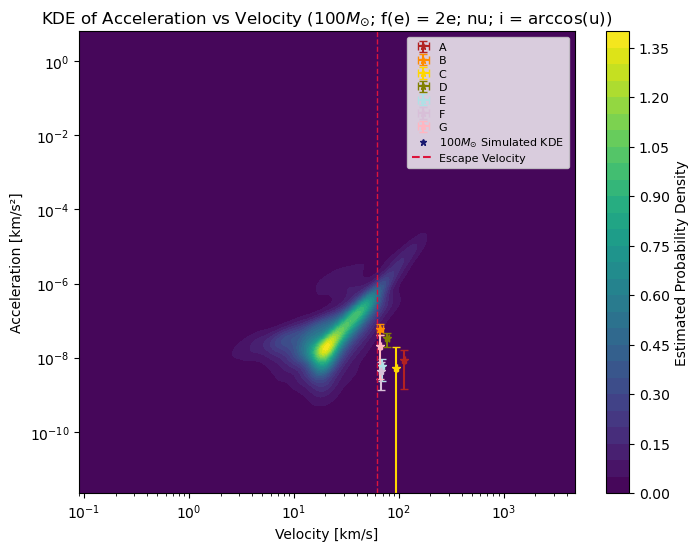

In [15]:
"""
Kernel Density Estimate of Calculated Stars 
(m_primary; f(e) = 2e; nu: i = arccos(u))
"""
# ========== Set Up Plot ==========
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(fr"KDE of Acceleration vs Velocity ({utils.m_primary}$M_{{\odot}}$; f(e) = 2e; nu; i = arccos(u))")

plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3
    )
# ========== Plot Escape Velocity Threshold ==========
plt.axvline(
    x=62,  # km/s average escape velocity
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== KDE for Simulated Stars ==========
velocities = v2_xy_i.flatten() / 1e3        # velocities in km/s
accelerations = a_xy_i.flatten()            # accelerations in km/s²

log_velocities = np.log10(velocities)
log_accelerations = np.log10(accelerations)

values = np.vstack([log_velocities, log_accelerations])

# Create grid in log-log space
x_grid, y_grid = np.mgrid[
    log_velocities.min():log_velocities.max():200j,
    log_accelerations.min():log_accelerations.max():200j
]

positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, x_grid.shape)

# Convert back to linear space for plotting
X_plot = 10 ** x_grid
Y_plot = 10 ** y_grid

# KDE contour plot (no scatter of simulated stars shown)
contour = plt.contourf(X_plot, Y_plot, Z, levels=30, cmap='viridis', alpha=1.0)

# Add colorbar to explain shading
cbar = plt.colorbar(contour)
cbar.set_label("Estimated Probability Density")

# ========== Legend Handling ==========
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None',
                            label=fr"{utils.m_primary}$M_{{\odot}}$ Simulated KDE")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

handles, legend_labels = plt.gca().get_legend_handles_labels()
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([fr"{utils.m_primary}$M_{{\odot}}$ Simulated KDE", 'Escape Velocity'])

plt.legend(
    handles=handles,
    labels=legend_labels,
    fontsize=8,
    loc='best',
    markerscale=0.8,
    handletextpad=0.4,
    borderpad=0.5,
    labelspacing=0.3
)

# ========== Plot Limits ==========

# plt.xlim(10, 250)    # Limits for velocity (km/s)
# plt.ylim(1e-11, 1e-5)   # Limits for acceleration (km/s²)

# ========== Save and Show ==========
i_plot_name = f"Acceleration_vs_Velocity_{utils.m_primary}_KDE_only"
i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{i_plot_name}_{i_timestamp}.png"

plt.savefig(i_filename)
plt.show()

In [16]:
"""
End TImer
"""
end_time = time.time()
total_time = end_time - start_time

minutes, seconds = divmod(total_time, 60)
print(f"Total runtime: {int(minutes)} min {seconds:.2f} sec")

Total runtime: 47 min 2.30 sec
